In [1]:
import requests
from requests import Session
from requests.exceptions import HTTPError
import pandas as pd
import numpy as np
from random import uniform
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, average_precision_score,make_scorer,precision_score
from sklearn.linear_model import LogisticRegression


In [2]:
# Create a class to retry failed requests
class ResilientSession(Session):
    """
    This class is supposed to retry requests that return temporary errors.
    At this moment it supports: 500, 502, 503, 504
    """

    def request(self, method, url, **kwargs):
        counter = 0

        while True:
            counter += 1

            r = super(ResilientSession, self).request(method, url, **kwargs)

            if r.status_code in [ 500, 502, 503, 504 ]:
                delay = 10 * counter
                logging.warn("Got recoverable error [%s] from %s %s, retry #%s in %ss" % (r.status_code, method, url, counter, delay))
                time.sleep(delay)
                continue

            return r

In [3]:
# Create session object
s = ResilientSession()

To download necessary data, I ran the following code. But this takes a long time, so as soon as I finish with a season, I save it to a CSV for quick re-loads. This block was not executed as part of this notebook as it was done in a previous trial and error notebook.

In [4]:
# read one of our files
df2015 = pd.read_csv('pitch_data_2015.csv')

In [5]:
df2018 = pd.read_csv('pitch_data_2018.csv')

In [6]:
df2015

,Unnamed: 0,season,game,batter,batSide,pitcher,pitchHand,count_balls,count_strikes,pitch_result,...,start_speed,pitch_number,result,result_rbi,result_type,hit_hardness,hit_angle,hit_speed,hit_distance,hit_trajectory
0,0,2015,413661,572761,L,452657,L,0,1,Called Strike,...,92.9,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2015,413661,572761,L,452657,L,0,2,Swinging Strike,...,92.8,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2015,413661,572761,L,452657,L,0,2,Foul,...,94.1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2015,413661,572761,L,452657,L,1,2,Ball,...,91.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2015,413661,572761,L,452657,L,2,2,Ball,...,75.4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714144,714144,2015,416072,593934,R,460024,R,1,1,Ball,...,79.1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
714145,714145,2015,416072,593934,R,460024,R,2,1,Ball,...,79.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
714146,714146,2015,416072,593934,R,460024,R,2,2,Swinging Strike,...,88.9,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
714147,714147,2015,416072,593934,R,460024,R,3,2,Ball,...,95.2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df2015.isnull().sum()

Unnamed: 0             0
season                 0
game                   0
batter                 0
batSide                0
pitcher                0
pitchHand              0
count_balls            0
count_strikes          0
pitch_result           0
pitch_type             0
breakY               641
break_length         641
spin_direction       641
spin_rate            653
end_speed            641
nasty_factor        1034
start_speed          641
pitch_number           0
result            527110
result_rbi        527109
result_type       527109
hit_hardness      581459
hit_angle         598442
hit_speed         598443
hit_distance      598457
hit_trajectory    581459
dtype: int64

In [17]:
df2018.isnull().sum()

Unnamed: 0             0
season                 0
game                   0
batter                 0
batSide                0
pitcher                0
pitchHand              0
count_balls            0
count_strikes          0
pitch_result           0
pitch_type             0
breakY              2895
break_length        2895
spin_direction      2895
spin_rate          14263
end_speed           2895
nasty_factor        2982
start_speed         2895
pitch_number           0
result            549425
result_rbi        549425
result_type       549425
hit_hardness      608995
hit_angle         620294
hit_speed         620219
hit_distance      620332
hit_trajectory    608995
dtype: int64

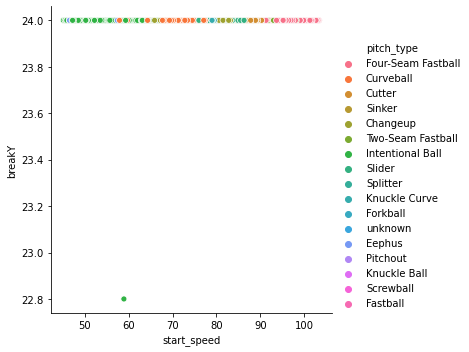

In [147]:
# hmm this seems off
sns.relplot(x="start_speed",y="breakY",hue="pitch_type",data=df2015)

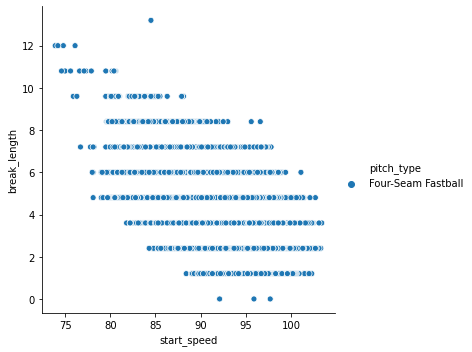

In [9]:
sns.relplot(x="start_speed",y="break_length",hue="pitch_type",data=df2015[df2015['pitch_type']=='Four-Seam Fastball'])

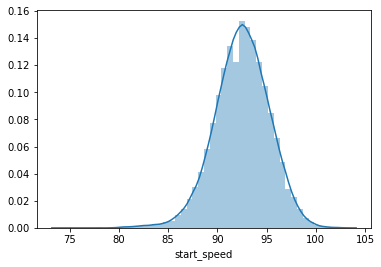

In [10]:
sns.distplot(df2015[df2015['pitch_type']=='Four-Seam Fastball']['start_speed'])

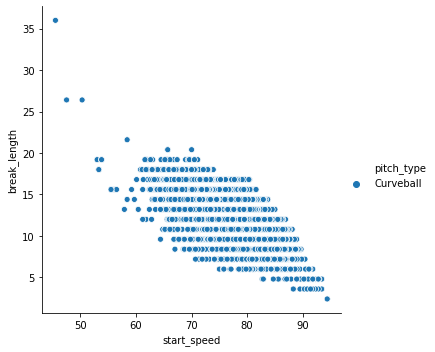

In [11]:
sns.relplot(x="start_speed",y="break_length",hue="pitch_type",data=df2015[df2015['pitch_type']=='Curveball'])

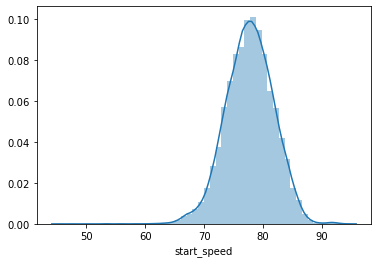

In [12]:
sns.distplot(df2015[df2015['pitch_type']=='Curveball']['start_speed'])

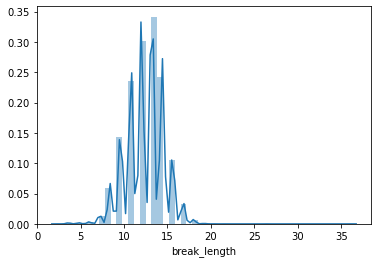

In [13]:
sns.distplot(df2015[df2015['pitch_type']=='Curveball']['break_length'])

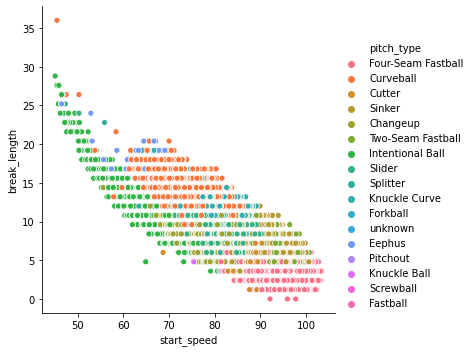

In [148]:
sns.relplot(x="start_speed",y="break_length",hue="pitch_type",data=df2015)

[Text(0, 0, 'Four-Seam Fastball'),
 Text(0, 0, 'Curveball'),
 Text(0, 0, 'Cutter'),
 Text(0, 0, 'Sinker'),
 Text(0, 0, 'Changeup'),
 Text(0, 0, 'Two-Seam Fastball'),
 Text(0, 0, 'Intentional Ball'),
 Text(0, 0, 'Slider'),
 Text(0, 0, 'Splitter'),
 Text(0, 0, 'Knuckle Curve'),
 Text(0, 0, 'Forkball'),
 Text(0, 0, 'unknown'),
 Text(0, 0, 'Eephus'),
 Text(0, 0, 'Pitchout'),
 Text(0, 0, 'Knuckle Ball'),
 Text(0, 0, 'Screwball'),
 Text(0, 0, 'Fastball')]

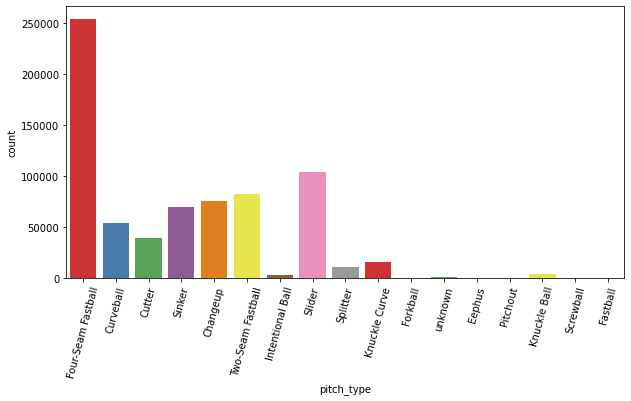

In [149]:
plt.figure(figsize=(10,5))
chart = sns.countplot(
    data=df2015,
    x='pitch_type',
    palette='Set1'
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=75)

[Text(0, 0, 'Two-Seam Fastball'),
 Text(0, 0, 'Changeup'),
 Text(0, 0, 'Slider'),
 Text(0, 0, 'Four-Seam Fastball'),
 Text(0, 0, 'Sinker'),
 Text(0, 0, 'Curveball'),
 Text(0, 0, 'Cutter'),
 Text(0, 0, 'Forkball'),
 Text(0, 0, 'unknown'),
 Text(0, 0, 'Splitter'),
 Text(0, 0, 'Knuckle Curve'),
 Text(0, 0, 'Eephus'),
 Text(0, 0, 'Pitchout'),
 Text(0, 0, 'Screwball'),
 Text(0, 0, 'Knuckle Ball')]

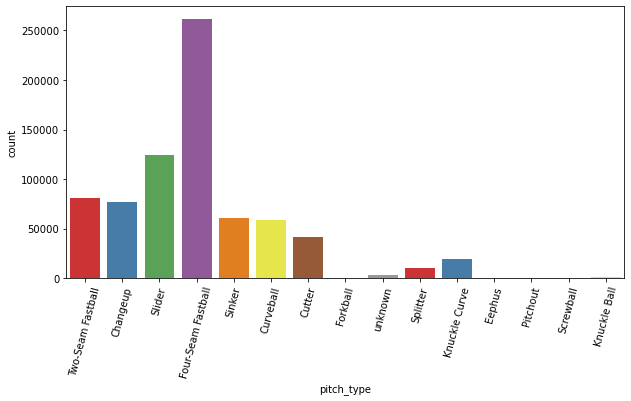

In [35]:
plt.figure(figsize=(10,5))
chart = sns.countplot(
    data=df2018,
    x='pitch_type',
    palette='Set1'
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=75)

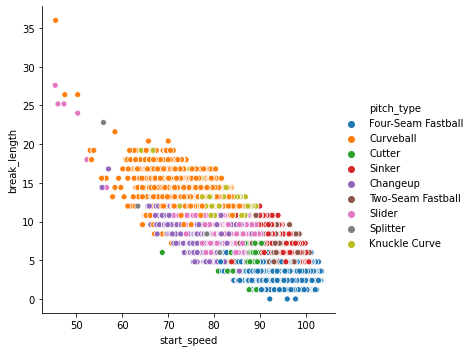

In [150]:
sns.relplot(x="start_speed",y="break_length",hue="pitch_type",data=df2015[df2015['pitch_type'].isin(
    ['Changeup','Curveball','Cutter','Four-Seam Fastball','Knuckle Curve',
     'Sinker','Slider','Splitter','Two-Seam Fastball'])])

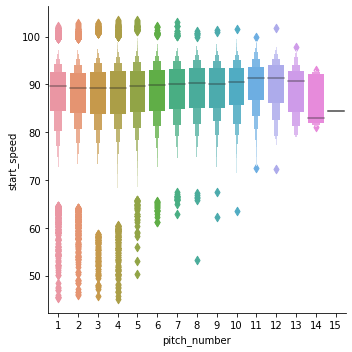

In [151]:
sns.catplot(x="pitch_number", y="start_speed", kind="boxen",
            data=df2015.sort_values("pitch_number"));

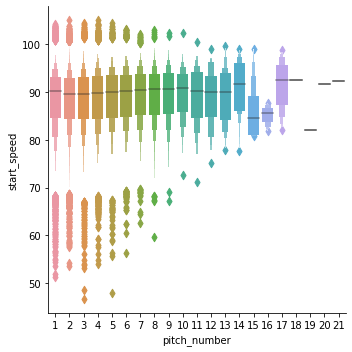

In [22]:
sns.catplot(x="pitch_number", y="start_speed", kind="boxen",
            data=df2018.sort_values("pitch_number"));

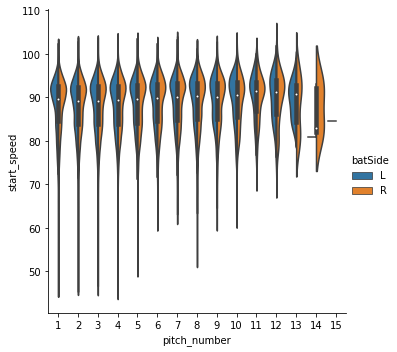

In [152]:
sns.catplot(x="pitch_number", y="start_speed", hue="batSide",
            kind="violin", split=True, data=df2015);

<Figure size 360x360 with 0 Axes>

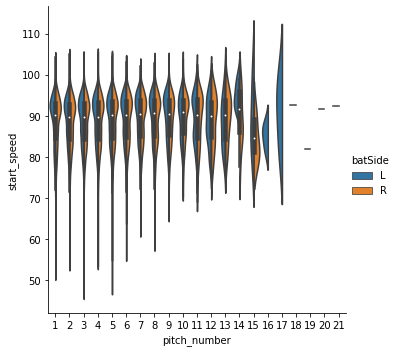

In [29]:
plt.figure(figsize=(5,5))
sns.catplot(x="pitch_number", y="start_speed", hue="batSide",
            kind="violin", split=True, data=df2018);

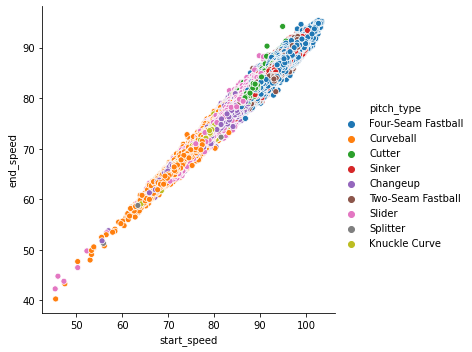

In [153]:
sns.relplot(x="start_speed",y="end_speed",hue="pitch_type",data=df2015[df2015['pitch_type'].isin(
    ['Changeup','Curveball','Cutter','Four-Seam Fastball','Knuckle Curve',
     'Sinker','Slider','Splitter','Two-Seam Fastball'])])

In [15]:
df2015[df2015['start_speed']<70]['pitch_type'].unique()

array(['Intentional Ball', 'Eephus', 'Curveball', 'Changeup',
       'Knuckle Ball', 'Slider', 'Cutter', 'Knuckle Curve', 'Splitter'],
      dtype=object)

In [16]:
df2015[df2015['start_speed']>100]['start_speed'].max()

103.4

[Text(0, 0, 'Four-Seam Fastball'),
 Text(0, 0, 'Cutter'),
 Text(0, 0, 'Curveball'),
 Text(0, 0, 'Changeup'),
 Text(0, 0, 'Intentional Ball'),
 Text(0, 0, 'Two-Seam Fastball'),
 Text(0, 0, 'Slider'),
 Text(0, 0, 'Splitter'),
 Text(0, 0, 'Sinker'),
 Text(0, 0, 'Forkball'),
 Text(0, 0, 'Knuckle Curve'),
 Text(0, 0, 'unknown'),
 Text(0, 0, 'Knuckle Ball'),
 Text(0, 0, 'Eephus'),
 Text(0, 0, 'Pitchout')]

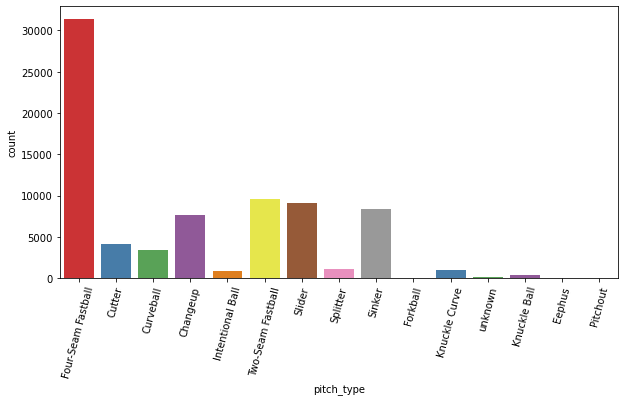

In [154]:
plt.figure(figsize=(10,5))
chart = sns.countplot(
    data=df2015[df2015["count_balls"]==3],
    x='pitch_type',
    palette='Set1'
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=75)

[Text(0, 0, 'Two-Seam Fastball'),
 Text(0, 0, 'Four-Seam Fastball'),
 Text(0, 0, 'Cutter'),
 Text(0, 0, 'Slider'),
 Text(0, 0, 'Forkball'),
 Text(0, 0, 'Curveball'),
 Text(0, 0, 'Changeup'),
 Text(0, 0, 'Sinker'),
 Text(0, 0, 'Splitter'),
 Text(0, 0, 'Knuckle Curve'),
 Text(0, 0, 'unknown'),
 Text(0, 0, 'Knuckle Ball'),
 Text(0, 0, 'Eephus'),
 Text(0, 0, 'Screwball')]

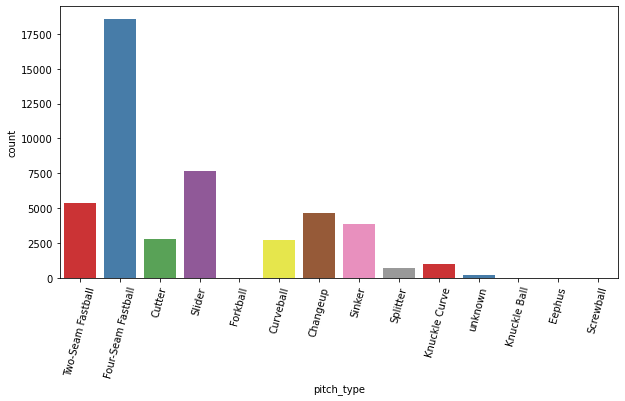

In [43]:
plt.figure(figsize=(10,5))
chart = sns.countplot(
    data=df2018[(df2018["count_balls"]==3) & (df2018["count_strikes"]==2)],
    x='pitch_type',
    palette='Set1'
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=75)

[Text(0, 0, 'Two-Seam Fastball'),
 Text(0, 0, 'Changeup'),
 Text(0, 0, 'Slider'),
 Text(0, 0, 'Four-Seam Fastball'),
 Text(0, 0, 'Cutter'),
 Text(0, 0, 'Sinker'),
 Text(0, 0, 'Curveball'),
 Text(0, 0, 'unknown'),
 Text(0, 0, 'Splitter'),
 Text(0, 0, 'Knuckle Curve'),
 Text(0, 0, 'Pitchout'),
 Text(0, 0, 'Eephus'),
 Text(0, 0, 'Forkball'),
 Text(0, 0, 'Knuckle Ball'),
 Text(0, 0, 'Screwball')]

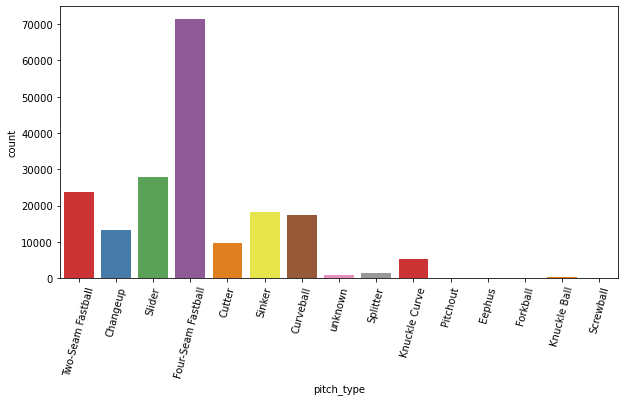

In [44]:
plt.figure(figsize=(10,5))
chart = sns.countplot(
    data=df2018[(df2018["pitch_number"]==1)],
    x='pitch_type',
    palette='Set1'
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=75)

[Text(0, 0, 'Two-Seam Fastball'),
 Text(0, 0, 'Cutter'),
 Text(0, 0, 'Four-Seam Fastball'),
 Text(0, 0, 'Changeup'),
 Text(0, 0, 'Slider'),
 Text(0, 0, 'Sinker'),
 Text(0, 0, 'Splitter'),
 Text(0, 0, 'Curveball'),
 Text(0, 0, 'Knuckle Curve'),
 Text(0, 0, 'unknown'),
 Text(0, 0, 'Forkball'),
 Text(0, 0, 'Knuckle Ball')]

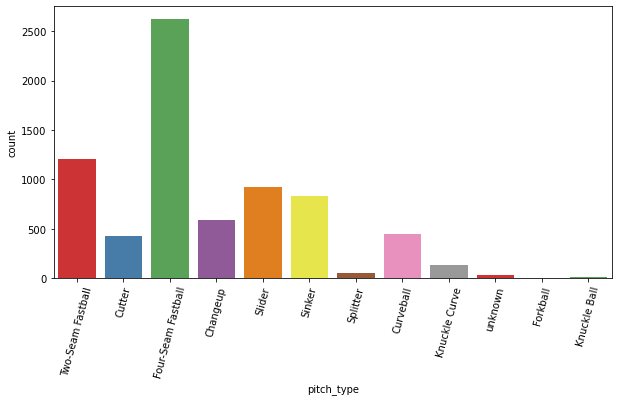

In [49]:
plt.figure(figsize=(10,5))
chart = sns.countplot(
    data=df2018[(df2018["pitch_number"]==1) & (df2018["pitch_result"].isin(['In play, run(s)','In play, no out']))],
    x='pitch_type',
    palette='Set1'
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=75)

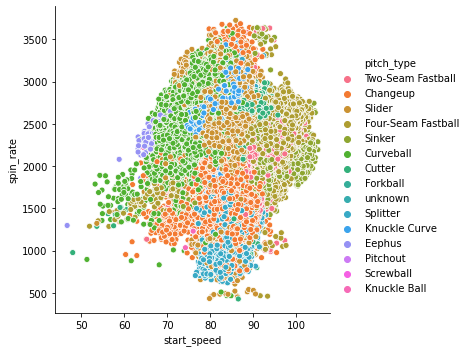

In [50]:
sns.relplot(x="start_speed",y="spin_rate",hue="pitch_type",data=df2018)

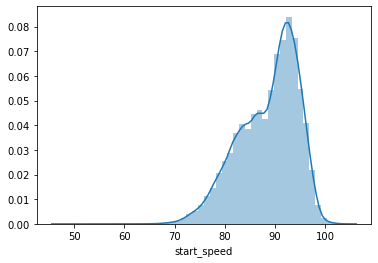

In [51]:
sns.distplot(df2018["start_speed"])

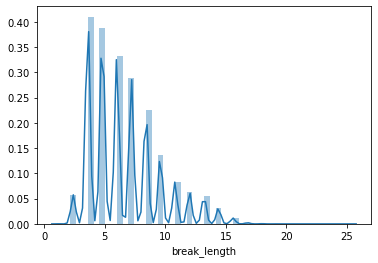

In [54]:
sns.distplot(df2018["break_length"])

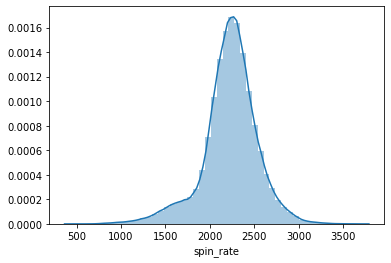

In [55]:
sns.distplot(df2018["spin_rate"])

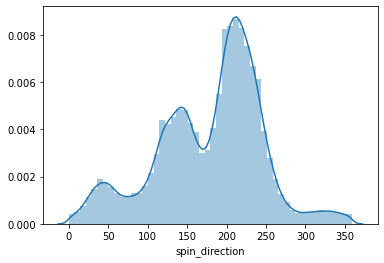

In [155]:
sns.distplot(df2015["spin_direction"])

In [156]:
df2015.columns

Index(['Unnamed: 0', 'season', 'game', 'batter', 'batSide', 'pitcher',
       'pitchHand', 'count_balls', 'count_strikes', 'pitch_result',
       'pitch_type', 'breakY', 'break_length', 'spin_direction', 'spin_rate',
       'end_speed', 'nasty_factor', 'start_speed', 'pitch_number', 'result',
       'result_rbi', 'result_type', 'hit_hardness', 'hit_angle', 'hit_speed',
       'hit_distance', 'hit_trajectory'],
      dtype='object')

In [57]:
def target_cat_bin(val):
    if (val in ['Single', 'Double', 'Triple', 'Home Run']):
        return 1
    else:
        return 0

In [157]:
def hithardness(val):
    if val == 'soft':
        return 1
    elif val == 'medium':
        return 2
    elif val == 'hard':
        return 3

In [158]:
# remove records that did not have a result of a ball hit
df2015.dropna(subset=['result','hit_hardness'], inplace=True)

In [159]:
# 2015 is my train
# Saved wrong, so drop an unneeded column
df2015.drop(['Unnamed: 0'], axis=1, inplace=True)

# While some of these columns may be useful for additional analysis, going to drop them for this project
df2015.drop(['season','game','batter','batSide','pitcher','pitchHand','breakY','pitch_number',
             'result_rbi', 'result_type','hit_trajectory','pitch_result','pitch_type'
            ], axis=1, inplace=True)

# Each season there are a few pitches that don't register, drop them
df2015.dropna(subset=['break_length', 'spin_direction','spin_rate',
                 'end_speed','start_speed','nasty_factor'], inplace=True)

df2015['count_balls'] = df2015['count_balls'].astype('category')
df2015['count_strikes'] = df2015['count_strikes'].astype('category')
df2015['hhcode'] = df2015['hit_hardness'].apply(hithardness)
df2015['hhcode'] = df2015['hhcode'].astype('category')
df2015.drop(['hit_hardness'], axis=1, inplace=True)

In [160]:
# create train/test sets by using different seasons of data
# train will be df2015 data
X_train = df2015.drop(['result'], axis=1)
Y_train = df2015['result']

In [161]:
# Map hit results to integer values and convert to categorical
y_cat_train = Y_train.map(target_cat_bin)

In [184]:
# remove records that did not have a result of a ball hit
df2018.dropna(subset=['result','hit_hardness'], inplace=True)

In [185]:
# 2018 is my test
# Saved wrong, so drop an unneeded column
df2018.drop(['Unnamed: 0'], axis=1, inplace=True)

# While some of these columns may be useful for additional analysis, going to drop them for this project
df2018.drop(['season','game','batter','batSide','pitcher','pitchHand','breakY','pitch_number',
             'result_rbi', 'result_type','hit_trajectory', 'pitch_result','pitch_type'
            ], axis=1, inplace=True)

# Each season there are a few pitches that don't register, drop them
df2018.dropna(subset=['break_length', 'spin_direction','spin_rate',
                 'end_speed','start_speed','nasty_factor'], inplace=True)

df2018['count_balls'] = df2018['count_balls'].astype('category')
df2018['count_strikes'] = df2018['count_strikes'].astype('category')
df2018['hhcode'] = df2018['hit_hardness'].apply(hithardness)
df2018['hhcode'] = df2018['hhcode'].astype('category')
df2018.drop(['hit_hardness'], axis=1, inplace=True)

In [186]:
X_test = df2018.drop(['result'], axis=1)
Y_test = df2018['result']

In [187]:
# Map hit results to integer values and convert to categorical
y_cat_test = Y_test.map(target_cat_bin)

In [188]:
X_train

,count_balls,count_strikes,break_length,spin_direction,spin_rate,end_speed,nasty_factor,start_speed,hit_angle,hit_speed,hit_distance,hhcode
5,2,2,3.6,148.0,2743.0,84.8,42.06,92.9,NaN,NaN,NaN,2
7,1,0,4.8,185.0,1433.0,82.4,39.25,89.3,NaN,NaN,NaN,2
10,2,0,4.8,137.0,2475.0,84.4,48.33,92.6,NaN,NaN,NaN,2
20,1,0,6.0,167.0,1307.0,80.7,18.14,87.5,24.21,73.53,209.00,1
24,1,2,4.8,175.0,1645.0,83.3,57.02,89.3,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...
714127,0,0,7.2,204.0,943.0,76.9,48.97,82.8,12.07,82.42,151.65,2
714134,2,2,7.2,114.0,934.0,84.2,44.74,90.3,44.49,77.52,230.83,2
714138,1,2,13.2,51.0,1762.0,72.9,54.84,79.2,4.11,70.76,60.92,2
714142,0,2,12.0,60.0,1601.0,73.8,47.60,79.5,-24.03,93.46,128.97,2


In [201]:
X_train.isnull().sum()

count_balls           0
count_strikes         0
break_length          0
spin_direction        0
spin_rate             0
end_speed             0
nasty_factor          0
start_speed           0
hit_angle         16948
hit_speed         16949
hit_distance      16963
hhcode                0
dtype: int64

In [190]:
X_test.isnull().sum()

count_balls           0
count_strikes         0
break_length          0
spin_direction        0
spin_rate             0
end_speed             0
nasty_factor          0
start_speed           0
hit_angle         10691
hit_speed         10618
hit_distance      10731
hhcode                0
dtype: int64

In [191]:
X_test

,count_balls,count_strikes,break_length,spin_direction,spin_rate,end_speed,nasty_factor,start_speed,hit_angle,hit_speed,hit_distance,hhcode
0,0,0,4.8,230.0,2168.0,87.1,32.89,95.5,30.59,106.98,392.43,2
22,2,2,6.0,234.0,1839.0,80.6,55.12,90.1,-15.55,71.61,7.75,2
35,2,2,6.0,242.0,2018.0,84.8,34.25,93.9,-8.19,85.74,14.63,2
38,1,1,7.2,117.0,1969.0,80.5,56.43,88.2,2.76,82.03,45.55,2
41,1,1,7.2,111.0,1889.0,82.5,42.58,88.9,-12.21,93.36,9.49,2
...,...,...,...,...,...,...,...,...,...,...,...,...
738196,0,1,4.8,130.0,2339.0,86.5,35.02,94.0,-15.53,65.71,104.59,2
738197,0,0,10.8,39.0,2627.0,76.7,66.46,81.9,-11.39,81.04,117.06,2
738198,0,0,4.8,162.0,2742.0,85.5,36.77,92.4,23.42,107.13,414.21,2
738207,3,2,4.8,152.0,2592.0,85.1,36.79,91.6,23.62,104.69,409.19,2


In [113]:
clf = Pipeline([('scaler', StandardScaler()),
               ('lr', LogisticRegression(random_state=0))
               ])

params = {'lr__C': [.1,1,10]
         }

grid = GridSearchCV(clf,
                       param_grid=params,
                       scoring={'avr': make_scorer(precision_score, needs_proba=True),
                                'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)},
                       n_jobs=-1,
                       cv=5,
                   refit='avr')

In [114]:
grid.fit(X_train,y_cat_train)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [98]:
y_cat_train = y_cat_train.astype('category')

In [214]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

In [215]:
X_train_imp = imp_mean.fit_transform(X_train)

In [216]:
scaler = StandardScaler()

In [217]:
scaler.fit(X_train_imp)

StandardScaler()

In [218]:
X_train_scaled = scaler.transform(X_train_imp)

In [220]:
lr = LogisticRegression(C=0.1,random_state=0).fit(X_train_scaled, y_cat_train)

In [221]:
lr.predict(X_train_imp)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [223]:
lr.score(X_train_scaled,y_cat_train)

0.7337800516140717

In [224]:
precision_score(y_cat_train,lr.predict(X_train_scaled))

0.6720559621977208

In [133]:
len(y_cat_train)

132345

In [134]:
len(lr.predict(X_train_scaled))

132345

In [209]:
set(y_cat_train) - set(lr.predict(X_train_scaled))

set()

In [225]:
y_pred = lr.predict(X_train_scaled)

In [226]:
np.unique(y_pred)

array([0, 1], dtype=int64)